In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**CONVOLUTION NEURAL NETWORKS**

**When should you use a Convolutional Neural Network instead of an Artificial Neural Network?**

1. CNNs work best when the data can be represented in a spatial manner, say an image in MxN pixels. If you data is just as useful after shuffling any of your columns with each other then you cannot use CNN.

2. For example take into consideration the titanic dataset which you worked on. It had two columns (or features), namely age and gender , and if I were to swap the two columns (before feeding it to my network) it would make no difference whatsoever to my dataset. ANNs are preferred for such datasets

3. On the contrary, if we were to swap the columns (which are essentially pixel arrays) in an image, we are surely going to mess up an actual image. Hence, using ANNs is a big no-no and you must use CNNs.

# PREPROCESSING

>**Dataset Directory Structure**

There is a standard way to lay out your image data for modeling.

After you have collected your images, you must sort them first by dataset, such as train, test, and validation, and second by their class.

For example, imagine an image classification problem where we wish to classify photos of cars based on their color, e.g. red cars, blue cars, etc.

The below image is how you should structure your data

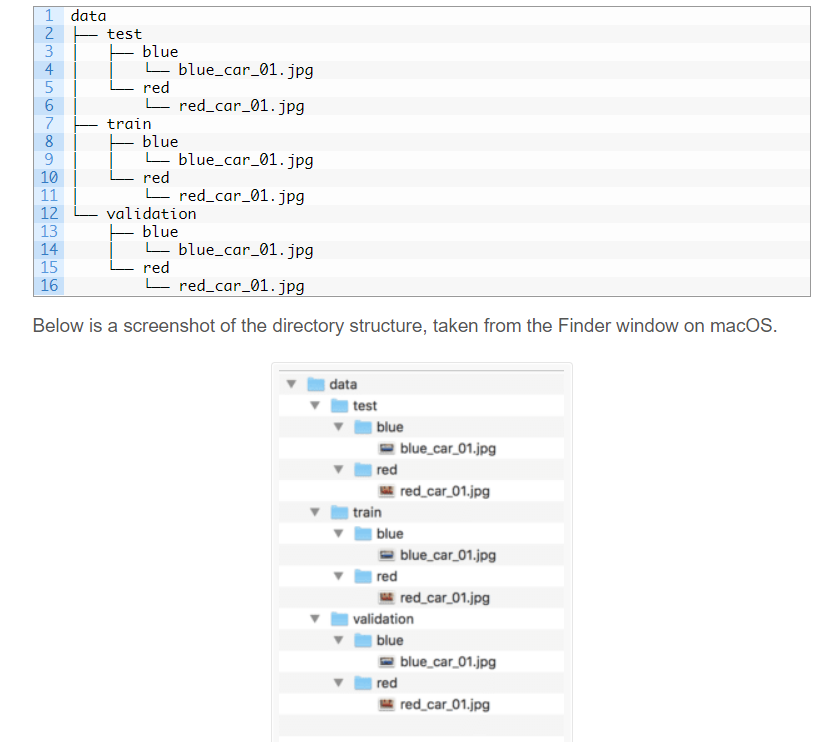

> **How to Progressively Load Images**

*   The main benefit of using this class to load the data is that images are loaded for a single dataset in batches, meaning that it can be used for loading both small datasets as well as very large image datasets with thousands or millions of images.

*   Instead of loading all images into memory, it will load just enough images into memory for the current and perhaps the next few mini-batches when training and evaluating a deep learning model. We refer to this as progressive loading, as the dataset is progressively loaded from file, retrieving just enough data for what is needed immediately.



*  Two additional benefits of the using the ImageDataGenerator 
class is that it can also automatically scale pixel values of images and it can automatically generate augmented versions of images. We will leave these topics for discussion later and instead focus on how to use the ImageDataGenerator class to load image data from file.

**Usual Pattern for using the ImageDataGenerator** class is used as follows:

In [ ]:
def process_data(img_dims, batch_size):
    # These are the Data generation objects
    train_datagen = ImageDataGenerator(rescale = 1./255)
    test_val_datagen = ImageDataGenerator(rescale = 1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    #train dataset batches is created
    train_gen = train_datagen.flow_from_directory(
    directory = input_path + 'train', 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'binary', 
    shuffle = True)
    #test dataset batches is created
    test_gen = test_val_datagen.flow_from_directory(
    directory = input_path+'test', 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'binary', 
    shuffle = True)

The ***target_size*** specifies what height and width we want the images to be resized to. This is important since we might have images of different sizes in our dataset.

***Batch size*** specifies how many training samples should be passed to the neural network in one go before the weights of the neural network are updated.

Common batch size value used in **32** but ideally, the most optimal value should be found by hyperparameter tuning (we will learn how to do so in the next tutorial).

#**Do Preprocess in the follow**

Now as you got an idea on why to preprocess lets start to do it with our dataset.

*   Download the dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
*  After downloading unzip it, you will see the chest_xray folder that contains images organized neatly into train, valid, and test subfolders. Each of these subfolders contains two sub-sub folders, one for normal chest Xrays and another for Xrays indicating pneumonia.

In [10]:
# Importing the required libraries

import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

Create the ImageDataGenerator class

Set the paths to the train, validate, and test folders

In [11]:
#write code here

train_path = '/content/drive/MyDrive/synapse_w7/train'
test_path = '/content/drive/MyDrive/synapse_w7/test'
valid_path = '/content/drive/MyDrive/synapse_w7/val'

In [12]:
def process_data(img_dims, batch_size):
    # create three Data generation objects for train test and validation
    train_datagen = ImageDataGenerator(rescale = 1./255)
    val_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)
 
    # Write the code for train, val, test batches which will be fed to the network in the specified batch sizes and image dimensions
     #solution for train_gen:(refer to this and similary write for test and validation batch)
    train_gen = train_datagen.flow_from_directory(
        directory = train_path, 
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'binary', 
        shuffle = True
    )
    val_gen = val_datagen.flow_from_directory(
        directory = valid_path,
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'binary', 
        shuffle = True
    )
    test_gen = test_datagen.flow_from_directory(
        directory = test_path,
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'binary', 
        shuffle = True
    )

    return train_gen, val_gen, test_gen

In [15]:
# run the cell and cross-check the output
# Hyperparameters
img_dims = 150
epochs = 10
batch_size = 32

# Getting the data
train_gen, val_gen , test_gen = process_data(img_dims, batch_size)

Found 5255 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The batch_size is set to 32 and the choice of 32 is arbitrary but ideally, the most optimal value should be found by hyperparameter tuning.

# VISUALIZE THE DATA

We need to visualize the images in the dataset. 

So using plt we can see the images. This is done to showcase the quality of our images and cross-check the imagedataset we are going to use.

We are taking into consideration you all are familiar with the plt  library below are the codes for your reference.

In [ ]:
normal_example = os.listdir('/content/drive/MyDrive/synapse_w7/train/NORMAL')[0]

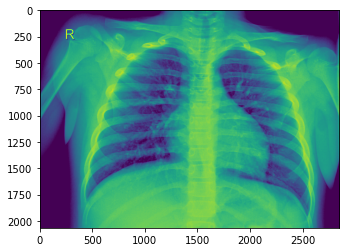

In [ ]:
normal_img = plt.imread(f'/content/drive/MyDrive/synapse_w7/train/NORMAL/{normal_example}')
plt.imshow(normal_img)

In [19]:
# plot images in the form of a 1 by 10 grid and resize img to 30x30

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (30, 30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes) :
      ax.imshow(img)
      ax.axis('off')
    plt.tight_layout()
    plt.show()

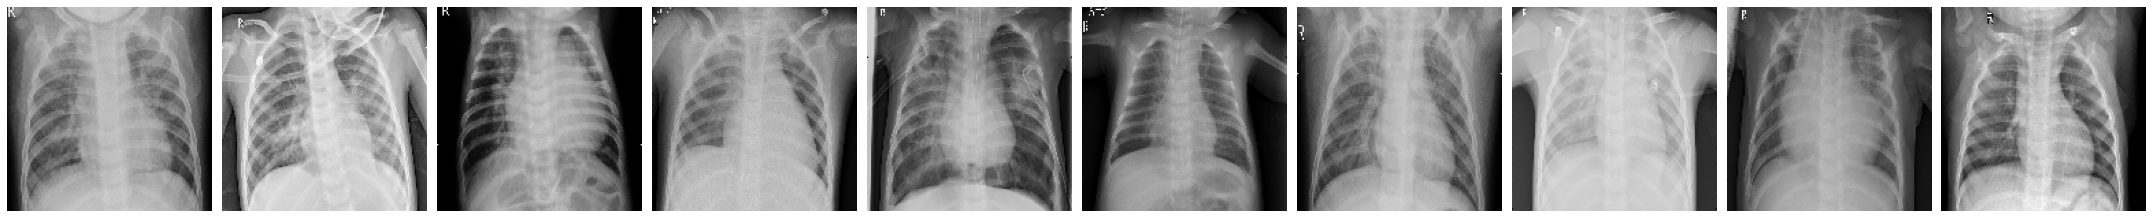

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1.]


In [20]:
imgs, labels = next(train_gen)
plotImages(imgs)
print(labels)

1---> Pneumonia

0--->Norma Xray

Using plt as in the above example visualize the images

1.   Show a image from train/pneumonia.
2.   Plot 10 images from the test batches as it was done for train batches.

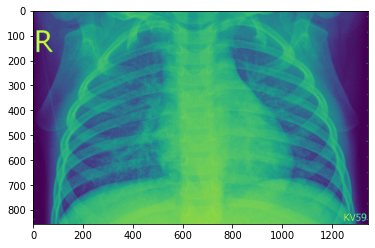

In [ ]:
#code here

pneumonia_example = os.listdir('/content/drive/MyDrive/synapse_w7/train/PNEUMONIA')[0]
pneumonia_img = plt.imread(f'/content/drive/MyDrive/synapse_w7/train/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)

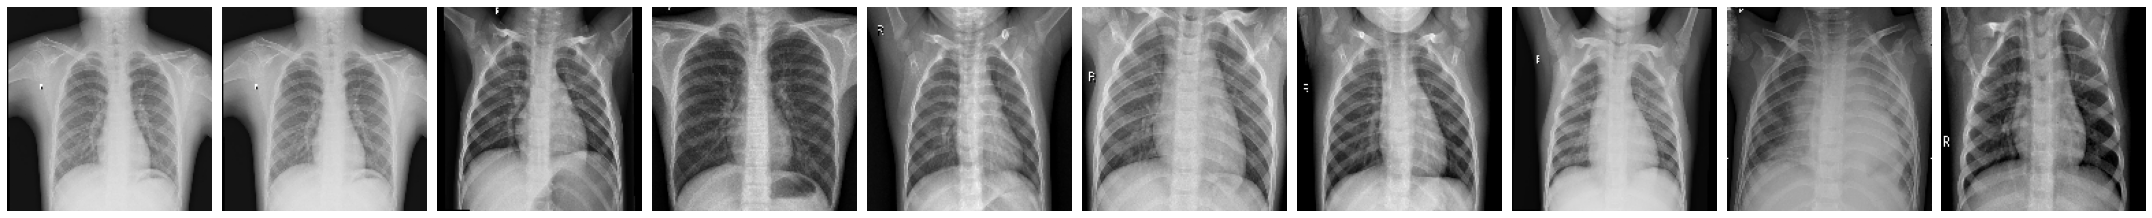

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 1. 0.]


In [ ]:
imgs, labels = next(test_gen)
plotImages(imgs)
print(labels)

# Creating the model

Recall we introduced a sequential model when we built an artificial neural network.
In short, the sequential API allows you to create models layer-by-layer

In [ ]:
#code
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (150,150,3)),
    MaxPool2D(pool_size = (2, 2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2, 2), strides = 2),
    Flatten(),
    Dense(units = 1, activation = 'softmax')
])

#read the text below to know what each layer is and what is their function 

> **First hidden layer** :
The first hidden layer is a standard convolutional layer, Conv2D, with 32 filters each with a kernel size of 3x3. Remember each filter is dedicated to identifying some aspect of the image, say filter1 detects vertical boundaries of the ribcage, filter2 detects diagonal boundaries of the ribcage, and so on... The patterns that the filters are encoding will become complex over time as we go deeper into the convolutional layers of the network.


**The choice of 32 is arbitrary!**

>**PADDING**:                
When a kernel reaches the edge of the image, it has to make some decision about what to do where there are no pixels present in the input image. For now, we are going forward with zero-padding the edges, achieved using **padding = 'same'**. Zero padding means providing a cushion of zeroes outside of the image (as seen in the gif image above). This helps to ensure the dimensionality of the input image isn’t reduced after the convolution operation.

> **MAX POOLING**:

**Second hidden layer** is a max-pooling layer, MaxPool2D, which is mainly for reducing the dimensionality of the data. The way it is doing that is by picking a window size ( pool_size = 2x2) from the filtered image (from convo/RELU layer) and then replace the 4 pixels in it with the highest value in that window. Next, it takes a stride of 2 steps to the right (or down or up) and replace those 4 pixels with the highest value. And so on until the entire image has been covered.

> **The third and fourth hidden layers** are again Conv2Dand MaxPool2D, respectively.



***Note:*** *The second Conv2D layer has filters = 64 , double the number of filters in the first Conv2D layer (which has 32 filters). This increment in functions is a common practice as we go into the later layers of the network.*

Finally, we flatten the output from the convolutional layer and pass it to the Dense layer with units = 2(corresponding to output classes pneumonia and normal) and softmax activation. The softmax function returns the output probabilities for both classes. 

ALWAYS VIEW THE SUMMARY OF THE MODEL TO GET A CLEAR IDEA OF YOUR MODEL

In [ ]:
#summary on the model and each of its layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 1)                 8

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Traning Model
hist = model.fit(
           train_gen, steps_per_epoch = train_gen.samples // batch_size, 
           epochs = epochs, validation_data = test_gen, 
           validation_steps = test_gen.samples // batch_size,
           verbose=2)

Epoch 1/10
164/164 - 850s - loss: 0.0000e+00 - accuracy: 0.7435 - val_loss: 0.0000e+00 - val_accuracy: 0.6250 - 850s/epoch - 5s/step
Epoch 2/10
164/164 - 74s - loss: 0.0000e+00 - accuracy: 0.7434 - val_loss: 0.0000e+00 - val_accuracy: 0.6283 - 74s/epoch - 451ms/step
Epoch 3/10
164/164 - 73s - loss: 0.0000e+00 - accuracy: 0.7444 - val_loss: 0.0000e+00 - val_accuracy: 0.6217 - 73s/epoch - 447ms/step
Epoch 4/10
164/164 - 73s - loss: 0.0000e+00 - accuracy: 0.7436 - val_loss: 0.0000e+00 - val_accuracy: 0.6234 - 73s/epoch - 443ms/step
Epoch 5/10
164/164 - 72s - loss: 0.0000e+00 - accuracy: 0.7436 - val_loss: 0.0000e+00 - val_accuracy: 0.6217 - 72s/epoch - 438ms/step
Epoch 6/10
164/164 - 71s - loss: 0.0000e+00 - accuracy: 0.7442 - val_loss: 0.0000e+00 - val_accuracy: 0.6217 - 71s/epoch - 434ms/step
Epoch 7/10
164/164 - 72s - loss: 0.0000e+00 - accuracy: 0.7440 - val_loss: 0.0000e+00 - val_accuracy: 0.6250 - 72s/epoch - 438ms/step
Epoch 8/10
164/164 - 71s - loss: 0.0000e+00 - accuracy: 0.7436 

1. If you observe carefully, we haven’t explicitly stated the labels for the training set (as we did for ANNs  using the y parameter) and the reason is that they are already incorporated within train_batches iterator.

2. The steps_per_epoch is calculated based on your training data. For example, if the number of samples in our train set is 1000 and the batch size is 20, then the steps_per_epoch is calculated by dividing 1000/20 = 50.

3. *Steps_per_epoch is an integer and corresponds to the total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to ceil(num_samples / batch_size).*

Now lets see how to include dropouts and batch normalizations in the code.

In [ ]:
def model_2():
    model = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (150,150,3)),
    BatchNormalization(),  #--------------batch normalization--------#
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(64, (3, 3), activation = "relu", padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(128, (3, 3), activation = "relu", padding = 'same'),  
     BatchNormalization(),
    MaxPool2D(pool_size = (3, 3)),
    Flatten(),
    Dense(120, activation = 'relu'),
    Dense(60, activation = 'relu'),
    Dropout(rate = 0.2),    #---------dropout-----------------------#
    Dense(1, activation = 'sigmoid') ,

    ])



    return model

In [ ]:
model_2 = model_2()
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
model_2.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = "accuracy")

In [ ]:
es = EarlyStopping(patience = 15, monitor = 'val_accuracy', restore_best_weights = True)

hist= model_2.fit(train_gen, steps_per_epoch = train_gen.samples // batch_size, 
           epochs = epochs, validation_data = test_gen, 
           validation_steps = test_gen.samples // batch_size,
           verbose=2,callbacks = [es])

Epoch 1/10
164/164 - 76s - loss: 0.3615 - accuracy: 0.9255 - val_loss: 6.4822 - val_accuracy: 0.4046 - 76s/epoch - 462ms/step
Epoch 2/10
164/164 - 73s - loss: 0.0984 - accuracy: 0.9648 - val_loss: 2.8740 - val_accuracy: 0.6250 - 73s/epoch - 447ms/step
Epoch 3/10
164/164 - 74s - loss: 0.0896 - accuracy: 0.9703 - val_loss: 2.7197 - val_accuracy: 0.6365 - 74s/epoch - 450ms/step
Epoch 4/10
164/164 - 72s - loss: 0.0722 - accuracy: 0.9728 - val_loss: 11.4482 - val_accuracy: 0.6283 - 72s/epoch - 437ms/step
Epoch 5/10
164/164 - 73s - loss: 0.0648 - accuracy: 0.9761 - val_loss: 1.1138 - val_accuracy: 0.7434 - 73s/epoch - 444ms/step
Epoch 6/10
164/164 - 73s - loss: 0.0458 - accuracy: 0.9830 - val_loss: 4.5849 - val_accuracy: 0.6349 - 73s/epoch - 447ms/step
Epoch 7/10
164/164 - 73s - loss: 0.0448 - accuracy: 0.9820 - val_loss: 0.6819 - val_accuracy: 0.7566 - 73s/epoch - 448ms/step
Epoch 8/10
164/164 - 72s - loss: 0.0331 - accuracy: 0.9860 - val_loss: 0.4482 - val_accuracy: 0.8586 - 72s/epoch - 44

**Now create a third model**

In [12]:
model_3 = model_3()
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_23 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_25 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                      

In [22]:
#the summary of a cnn model is provided above according to the summary,  Code the model 
#hint: the output shape column has (150 150 16)  the 150 X150 was the input shape and 16 was the number of filters
#to get a better understanding refer the two models above and compare the models with their model summary
#keep the rate of dropout 0.2 for all the dropouts in the model 
def model_4():
    model = Sequential([
    Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (150, 150, 3)),
    Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2, 2)),
    Dropout(rate = 0.2),
    Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2, 2)),
    Dropout(rate = 0.2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(rate = 0.2),
    Dense(128, activation = 'relu'),
    Dropout(rate = 0.2),
    Dense(64, activation = 'relu'),
    Dropout(rate = 0.2),
    Dense(1, activation = 'relu')
    ])


    return model

In [23]:
#print the summary of model 4 to cross check
model_4 = model_4()
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                          

compile and fit the model

In [24]:
#write the code here

model_4.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = "accuracy")

es_4 = EarlyStopping(patience = 15, monitor = 'val_accuracy', restore_best_weights = True)

hist_4 = model_4.fit(train_gen, steps_per_epoch = train_gen.samples // batch_size, 
                   epochs = epochs, validation_data = test_gen, 
                   validation_steps = test_gen.samples // batch_size,
                   verbose=2, callbacks= [es_4])

Epoch 1/10
164/164 - 1001s - loss: 3.9101 - accuracy: 0.7425 - val_loss: 5.7937 - val_accuracy: 0.6201 - 1001s/epoch - 6s/step
Epoch 2/10
164/164 - 77s - loss: 3.9065 - accuracy: 0.7438 - val_loss: 5.7686 - val_accuracy: 0.6217 - 77s/epoch - 468ms/step
Epoch 3/10
164/164 - 76s - loss: 3.9006 - accuracy: 0.7442 - val_loss: 5.7185 - val_accuracy: 0.6250 - 76s/epoch - 466ms/step
Epoch 4/10
164/164 - 77s - loss: 3.9006 - accuracy: 0.7442 - val_loss: 5.7185 - val_accuracy: 0.6250 - 77s/epoch - 468ms/step
Epoch 5/10
164/164 - 77s - loss: 3.9006 - accuracy: 0.7442 - val_loss: 5.6934 - val_accuracy: 0.6266 - 77s/epoch - 473ms/step
Epoch 6/10
164/164 - 75s - loss: 3.9123 - accuracy: 0.7434 - val_loss: 5.6934 - val_accuracy: 0.6266 - 75s/epoch - 457ms/step
Epoch 7/10
164/164 - 77s - loss: 3.8977 - accuracy: 0.7444 - val_loss: 5.7185 - val_accuracy: 0.6250 - 77s/epoch - 467ms/step
Epoch 8/10
164/164 - 76s - loss: 3.9065 - accuracy: 0.7438 - val_loss: 5.6181 - val_accuracy: 0.6316 - 76s/epoch - 46

# DATA AUGMENTATION

Download the image https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTrqWUxvjvW1PfKP4HLmhEG4fN4x1qEbPD3qw&usqp=CAU using wget (save it as aug.jpg)

In [3]:
#download the image

!wget -O aug.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTrqWUxvjvW1PfKP4HLmhEG4fN4x1qEbPD3qw&usqp=CAU

--2021-11-22 13:03:25--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTrqWUxvjvW1PfKP4HLmhEG4fN4x1qEbPD3qw
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 142.250.157.113, 142.250.157.102, 142.250.157.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|142.250.157.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3069 (3.0K) [image/jpeg]
Saving to: ‘aug.jpg’

aug.jpg             100%[===================>]   3.00K  --.-KB/s    in 0s      

2021-11-22 13:03:25 (26.8 MB/s) - ‘aug.jpg’ saved [3069/3069]



In [21]:
!ls

aug.jpg  drive	sample_data


write code and display output for Horizontal and vertical shift image augmentation

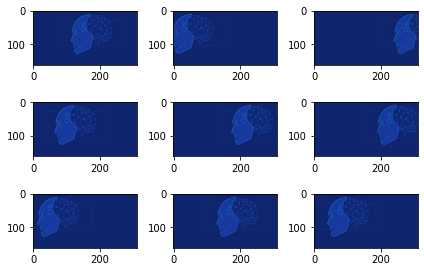

In [14]:
# horizontal shift image augmentation
#steps:-

# load the image
img = load_img('aug.jpg')

# convert to numpy array
data = img_to_array(img)

#(fill the code for following steps)

# expand dimension to one sample
sample = np.expand_dims(data, 0)

# create image data augmentation generator
data_aug_gen = ImageDataGenerator(width_shift_range = 0.5)

# prepare iterator
it = data_aug_gen.flow(sample, batch_size = 1)

# generate samples and plot
for i in range(9) :
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)


# show the figure
plt.tight_layout()
plt.show()

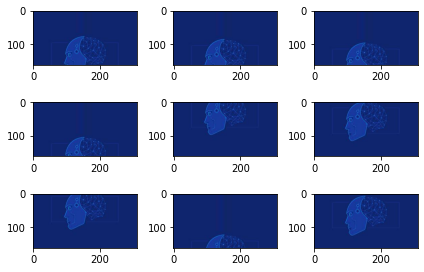

In [18]:
# vertical shift image augmentation

#steps:-

# load the image
img = load_img('aug.jpg')

# convert to numpy array
data = img_to_array(img)

#(fill the code for following steps)

# expand dimension to one sample
sample = np.expand_dims(data, 0)

# create image data augmentation generator
data_aug_gen = ImageDataGenerator(height_shift_range = 0.8)

# prepare iterator
it = data_aug_gen.flow(sample, batch_size = 1)

# generate samples and plot
for i in range(9) :
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)


# show the figure
plt.tight_layout()
plt.show()

Write code and display output for Horizontal and vertical flip image augmentation

Horizontal Flip Images :


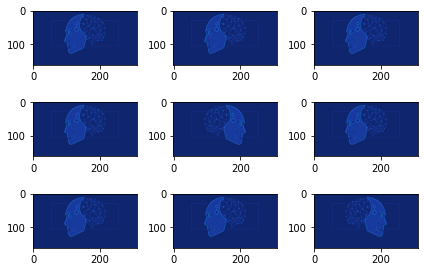




Vertical Flip Images :


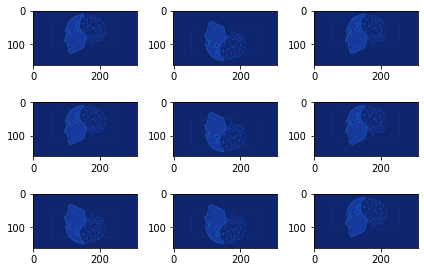

In [22]:
#code here

# horizontal flip and vertical flip image augmentation

#steps:-

# load the image
img = load_img('aug.jpg')

# convert to numpy array
data = img_to_array(img)

# expand dimension to one sample
sample = np.expand_dims(data, 0)

# create image data augmentation generator
data_aug_gen_horizontal = ImageDataGenerator(horizontal_flip = True)
data_aug_gen_vertical = ImageDataGenerator(vertical_flip = True)

# prepare iterator
it_horizontal = data_aug_gen_horizontal.flow(sample, batch_size = 1)
it_vertical = data_aug_gen_vertical.flow(sample, batch_size = 1)

# generate samples and plot for horizontal flip
for i in range(9) :
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it_horizontal.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)

# show the figure
print('Horizontal Flip Images :')
plt.tight_layout()
plt.show()
print('\n\n')

# generate samples and plot for vertical flip
for i in range(9) :
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it_vertical.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)

# show the figure
print('Vertical Flip Images :')
plt.tight_layout()
plt.show()

Random Rotation Augmentation

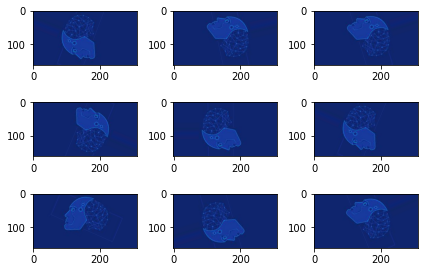

In [25]:
#code here

# random rotation augmentation

#steps:-

# load the image
img = load_img('aug.jpg')

# convert to numpy array
data = img_to_array(img)

# expand dimension to one sample
sample = np.expand_dims(data, 0)

# create image data augmentation generator
data_aug_gen = ImageDataGenerator(rotation_range = 120)

# prepare iterator
it = data_aug_gen.flow(sample, batch_size = 1)

# generate samples and plot
for i in range(9) :
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)


# show the figure
plt.tight_layout()
plt.show()

Random Brightness Augmentation

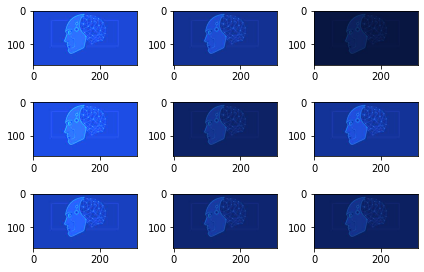

In [30]:
#code here

# random brightness augmentation

#steps:-

# load the image
img = load_img('aug.jpg')

# convert to numpy array
data = img_to_array(img)

# expand dimension to one sample
sample = np.expand_dims(data, 0)

# create image data augmentation generator
data_aug_gen = ImageDataGenerator(brightness_range = [0.4, 2.0])

# prepare iterator
it = data_aug_gen.flow(sample, batch_size = 1)

# generate samples and plot
for i in range(9) :
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)


# show the figure
plt.tight_layout()
plt.show()

Random Zoom Augmentation

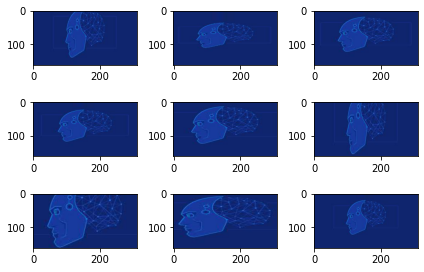

In [31]:
#code here

# random zoom augmentation


#steps:-

# load the image
img = load_img('aug.jpg')

# convert to numpy array
data = img_to_array(img)

# expand dimension to one sample
sample = np.expand_dims(data, 0)

# create image data augmentation generator
data_aug_gen = ImageDataGenerator(zoom_range = [0.4, 1.6])

# prepare iterator
it = data_aug_gen.flow(sample, batch_size = 1)

# generate samples and plot
for i in range(9) :
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)


# show the figure
plt.tight_layout()
plt.show()